In [22]:

import numpy as np

import time
import hopsworks
import os
from dotenv import load_dotenv
import joblib
from datetime import datetime, timedelta, date
import pandas as pd

import hopsworks
import matplotlib.pyplot as plt

from utils import *
import utils
from functools import reduce



In [23]:
load_dotenv()
#os.environ["HOPSWORKS_API_KEY"] = os.getenv("HOPSWORKS_API_KEY")


project = hopsworks.login()

2025-01-07 17:39:46,001 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 17:39:46,004 INFO: Initializing external client
2025-01-07 17:39:46,005 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 17:39:47,942 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160346


In [24]:

fs = project.get_feature_store() 
#secrets = secrets_api(project.name)

# This line will fail if you have not registered the CRYPTO_API_KEY as a secret in Hopsworks
#CRYPTO_API_KEY = secrets.get_secret("CRYPTO_API_KEY").value

#CRYPTO_API_KEY = os.getenv("CRYPTO_API_KEY")



In [25]:
#Step 1: get the  forcasted data
solana_pred_feature_group = fs.get_feature_group(
    name="solana_predictions",  
    version=4
)

#Step 2: get the actual data
solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=1
)




In [26]:
# Step 3: Read the data from the feature group
solana_pred_df = solana_pred_feature_group.select(["date","open_solana"]).read()

# Step 4: Read the data from the feature group
solana_actual_df = solana_feature_group.select(["timestamp","open"]).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 


In [27]:
solana_pred_df

,date,open_solana
0,2025-01-09 00:00:00+00:00,197.028580
1,2025-01-03 00:00:00+00:00,198.000000
2,2025-01-10 00:00:00+00:00,206.180145
3,2025-01-12 00:00:00+00:00,193.304733
4,2025-01-05 00:00:00+00:00,202.000000
5,2025-01-04 00:00:00+00:00,200.000000
6,2025-01-11 00:00:00+00:00,192.707794
7,2025-01-14 00:00:00+00:00,190.756165
8,2025-01-13 00:00:00+00:00,195.172897
9,2025-01-08 00:00:00+00:00,200.028061


In [28]:
solana_pred_df['date'] = pd.to_datetime(solana_pred_df['date'], errors='coerce')

solana_pred_df['date'] = solana_pred_df['date'].dt.normalize()
solana_pred_df['date'] = solana_pred_df['date'].dt.tz_localize(None)
solana_pred_df.rename(columns={'open_solana': 'solana_open_pred'}, inplace=True)
solana_pred_df = solana_pred_df.sort_values(by='date')

solana_pred_df



,date,solana_open_pred
1,2025-01-03,198.000000
5,2025-01-04,200.000000
4,2025-01-05,202.000000
12,2025-01-06,197.873077
11,2025-01-07,205.352615
9,2025-01-08,200.028061
0,2025-01-09,197.028580
2,2025-01-10,206.180145
6,2025-01-11,192.707794
3,2025-01-12,193.304733


In [29]:

solana_actual_df['date'] = pd.to_datetime(solana_actual_df['timestamp'], unit='s')
solana_actual_df['date'] = pd.to_datetime(solana_actual_df['date'], errors='coerce')

solana_actual_df['date'] = solana_actual_df['date'].dt.normalize()
solana_actual_df['date'] = solana_actual_df['date'].dt.tz_localize(None)
solana_actual_df.drop(columns=["timestamp"], inplace=True)
solana_actual_df.rename(columns={'open': 'solana_open_actual'}, inplace=True)
solana_actual_df = solana_actual_df.sort_values(by='date')


solana_actual_df

,solana_open_actual,date
986,40.23,2021-06-17
829,39.13,2021-06-18
48,36.62,2021-06-19
1246,35.45,2021-06-20
1194,35.28,2021-06-21
...,...,...
1295,191.06,2024-12-31
1293,188.95,2025-01-01
1288,193.82,2025-01-02
1290,208.00,2025-01-03


<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

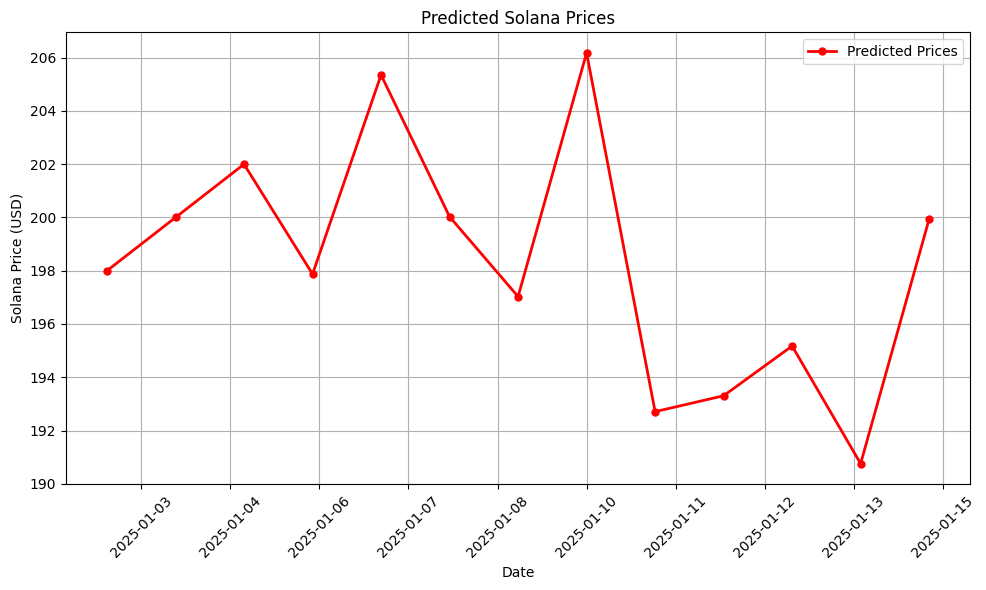

In [30]:
file_path='docs/assets/img/solana_predictions_plot.png'

plot_solana_predictions(solana_pred_df, file_path) 

In [31]:

solana_actual_df['date'] = pd.to_datetime(solana_actual_df['date'], errors='coerce')

solana_actual_df['date'] = solana_actual_df['date'].dt.normalize()
solana_actual_df['date'] = solana_actual_df['date'].dt.tz_localize(None)

solana_pred_df['date'] = pd.to_datetime(solana_pred_df['date'], errors='coerce')

solana_pred_df['date'] = solana_pred_df['date'].dt.normalize()
solana_pred_df['date'] = solana_pred_df['date'].dt.tz_localize(None)

In [32]:
# Merge the two df on date
pred_actual_join = solana_pred_df.merge(solana_actual_df, left_on='date', right_on='date')

# Show the results
pred_actual_join

,date,solana_open_pred,solana_open_actual
0,2025-01-03,198.0,208.0
1,2025-01-04,200.0,217.7


<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

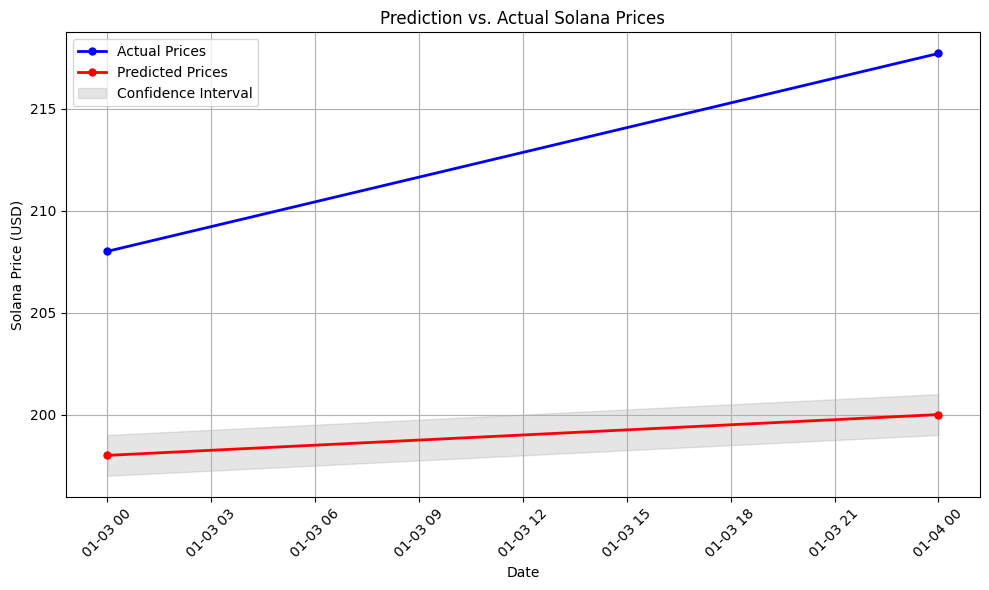

In [33]:
file_path='docs/assets/img/solana_actual_vs_predictions_plot.png'
confidence_upper = [p + 1 for p in pred_actual_join['solana_open_pred']]
confidence_lower = [p - 1 for p in pred_actual_join['solana_open_pred']]
plot_solana_actual_vs_predictions(pred_actual_join, confidence_lower, confidence_upper, file_path)


In [34]:
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=1
)

# Read the data from the feature group
btc_df = bitcoin_feature_group.select(["timestamp","open"]).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


In [35]:
btc_df['date'] = pd.to_datetime(btc_df['timestamp'], unit='s')
btc_df['date'] = pd.to_datetime(btc_df['date'], errors='coerce')

btc_df['date'] = btc_df['date'].dt.normalize()
btc_df['date'] = btc_df['date'].dt.tz_localize(None)
btc_df.drop(columns=["timestamp"], inplace=True)
btc_df.rename(columns={'open': 'btc_open'}, inplace=True)
#btc_df = btc_df.sort_values(by='date')


btc_df

,btc_open,date
0,27589.7,2023-04-24
1,40095.8,2022-02-20
2,24313.6,2022-08-15
3,69317.0,2024-06-08
4,22827.9,2022-08-04
...,...,...
1307,98111.1,2025-01-04
1308,93370.9,2025-01-01
1309,98647.2,2024-12-25
1310,99310.8,2024-12-26


In [36]:
fng_feature_group = fs.get_feature_group(
    name='f_n_g_index', 
    version=1)
fng_df = fng_feature_group.select(["timestamp","fng_value"]).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 


In [37]:
fng_df['date'] = pd.to_datetime(fng_df['timestamp'], unit='s')
fng_df['date'] = pd.to_datetime(fng_df['date'], errors='coerce')

fng_df['date'] = fng_df['date'].dt.normalize()
fng_df['date'] = fng_df['date'].dt.tz_localize(None)
fng_df.drop(columns=["timestamp"], inplace=True)
#fng_df.rename(columns={'value': 'fng_value'}, inplace=True)
#fng_df = fng_df.sort_values(by='date')


fng_df

,fng_value,date
0,74,2024-06-15
1,77,2024-03-18
2,43,2019-02-15
3,68,2024-07-26
4,30,2022-08-04
...,...,...
2521,50,2020-05-18
2522,79,2024-02-13
2523,27,2022-02-25
2524,28,2018-11-19


In [38]:

# List of DataFrames to merge
dfs = [btc_df, solana_actual_df, fng_df]

# Merge all DataFrames on 'date'
sln_btc_fng_join = reduce(lambda left, right: left.merge(right, on='date', how='inner'), dfs)
sln_btc_fng_join = sln_btc_fng_join.sort_values(by='date')

sln_btc_fng_join

,btc_open,date,solana_open_actual,fng_value
986,38337.1,2021-06-17,40.23,26
829,38078.2,2021-06-18,39.13,25
48,35824.0,2021-06-19,36.62,23
1245,35490.5,2021-06-20,35.45,21
1193,35595.0,2021-06-21,35.28,23
...,...,...,...,...
1296,92611.3,2024-12-31,191.06,64
1293,93370.9,2025-01-01,188.95,66
1287,94380.8,2025-01-02,193.82,70
1285,96805.2,2025-01-03,208.00,74


<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

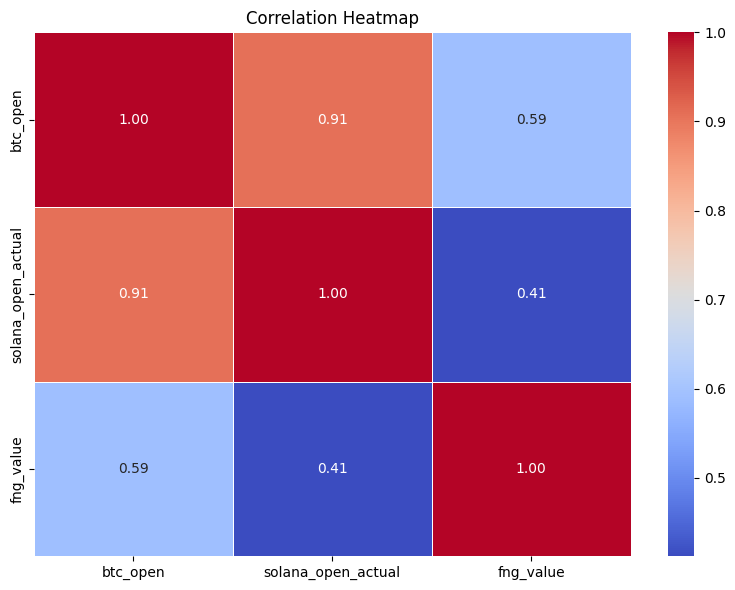

In [39]:
file_path='docs/assets/img/sln_btc_fng_heatmap.png'

plot_correlation_heatmap(sln_btc_fng_join,file_path)

In [40]:
# List of DataFrames to merge
dfs = [btc_df, solana_actual_df,solana_pred_df, fng_df]

# Merge all DataFrames on 'date'
trend_join = reduce(lambda left, right: left.merge(right, on='date', how='inner'), dfs)
trend_join = trend_join.sort_values(by='date')

trend_join

,btc_open,date,solana_open_actual,solana_open_pred,fng_value
0,96805.2,2025-01-03,208.0,198.0,74
1,98111.1,2025-01-04,217.7,200.0,73


2025-01-07 17:39:59,291 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-07 17:39:59,292 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

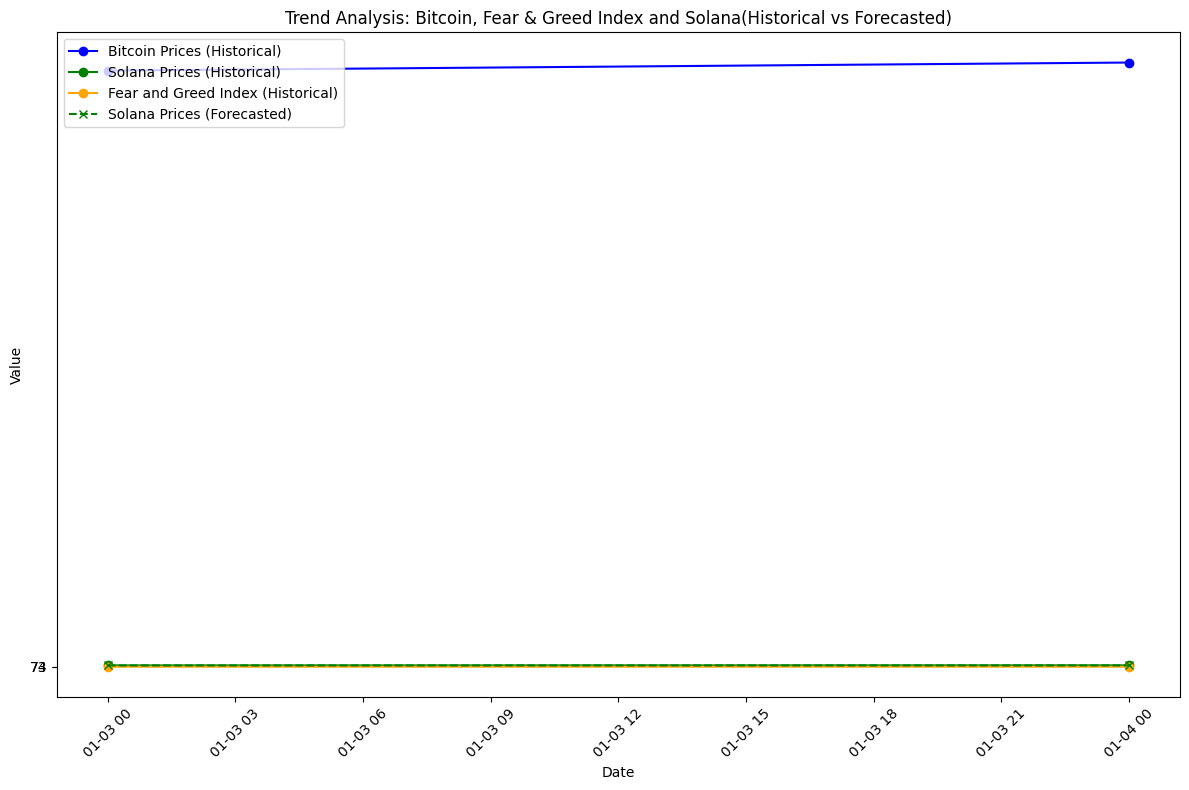

In [41]:
file_path='docs/assets/img/trend_analisis_table.png'

trend_join['bitcoin_actual_change'] = trend_join['btc_open'].pct_change() * 100
trend_join['solana_actual_change'] = trend_join['solana_open_actual'].pct_change() * 100
trend_join['solana_predicted_change'] = trend_join['solana_open_pred'].pct_change() * 100
trend_join = trend_join[['bitcoin_actual_change', 'solana_actual_change', 'solana_predicted_change', "fng_value"]]


plot_trend_analysis_table(trend_join,file_path)

In [49]:
generate_trend_table(trend_join)

,date,solana_change,solana_pred_change,bitcoin_change,fng_value_change
0,2025-01-03,NaN,NaN,NaN,NaN
1,2025-01-04,9.7,2.0,1305.9,-1.0
